In [1]:
import pandas as pd
import numpy as np
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import moviepy.video.io.ImageSequenceClip

device="cpu"

In [2]:
data = pd.read_csv('dataset_v3.csv')
data.head()

,Variance of Wavelet Transformed image,Skewness of Wavelet Transformed image,Kurtosis of Wavelet Transformed image,Entropy of image,Label
0,-3.56810,-8.2130,10.08300,0.967650,1.0
1,-1.77810,0.8546,7.13030,0.027572,0.0
2,-0.36025,-4.4490,2.10670,0.943080,1.0
3,0.59823,3.5012,-3.97950,-1.784100,1.0
4,-4.14090,3.4619,-0.47841,-3.887900,1.0


In [3]:
def load_dataset(data_set,batch_size=512):
    dataset=data_set
    dataset = shuffle(dataset, random_state=42)
    data = dataset.drop('Label', axis=1).values
    target = dataset['Label'].values

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
    # scaler = StandardScaler()
    # train_data = scaler.fit_transform(train_data)
    # test_data = scaler.transform(test_data)

    # Convert to PyTorch tensors
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_target = torch.tensor(train_target, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_target = torch.tensor(test_target, dtype=torch.long)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=batch_size, shuffle=false)

    train_inputs = torch.empty(0, 4, device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, 4, device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels
    dataset['test_label'] = test_labels

    return dataset

dataset = load_dataset(data,batch_size=512)

In [4]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))

Train data shape: torch.Size([392, 4])
Train target shape: torch.Size([392])
Test data shape: torch.Size([98, 4])
Test target shape: torch.Size([98])


In [5]:
# column_names = ["Variance", "Skewness", "Kurtosis", "Entropy"]
column_names = ["Var", "Skew", "Kurt", "Entp"]
target_names = ["Real", "Fake"]

checkpoint directory created: ./model
saving model version 0.0


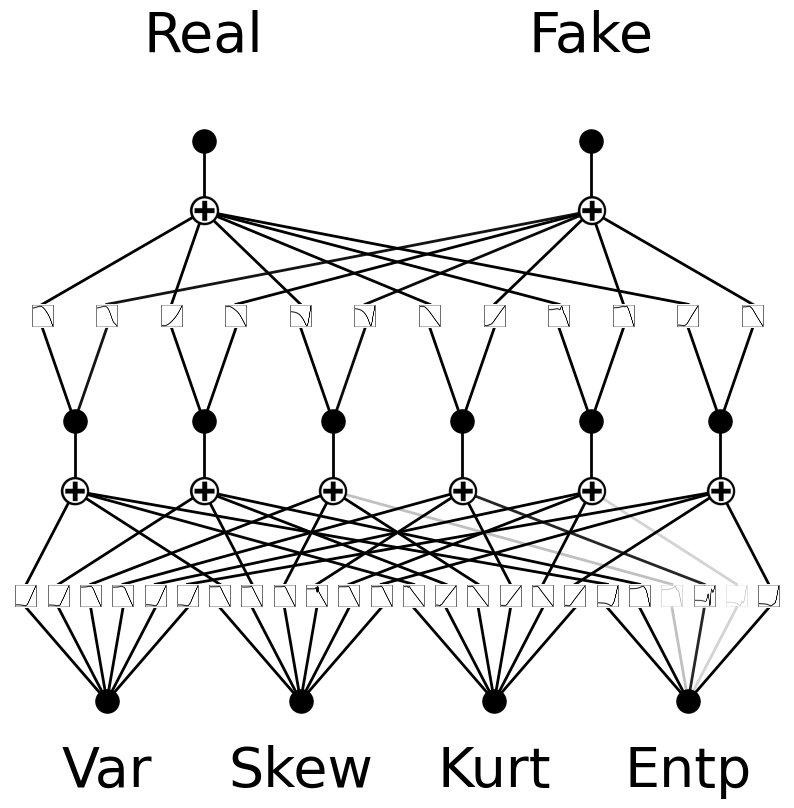

In [6]:
image_folder = 'video_img'

model = KAN(width=[4, 6, 2], grid=3, k=3, seed=0, device=device)

model(dataset['train_input'])
model.plot(beta=100, scale=1, in_vars=column_names, out_vars=target_names)

| train_loss: 1.11e-01 | test_loss: 1.25e-01 | reg: 4.99e+01 | : 100%|█| 100/100 [17:32<00:00, 10.53


saving model version 0.1


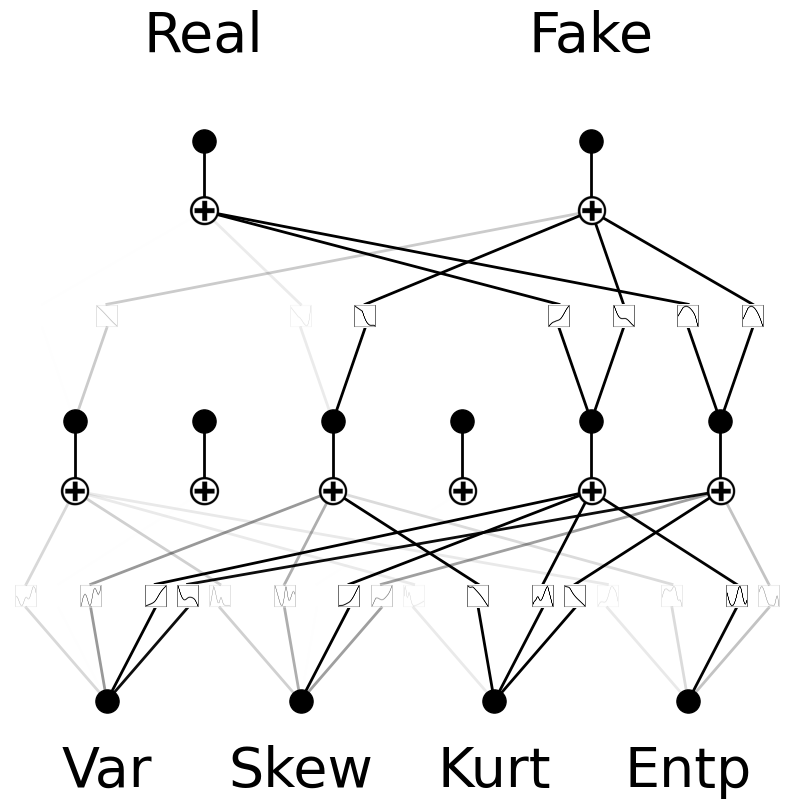

In [7]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = model.fit(dataset, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=100, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)
model.plot(beta=100, scale=1, in_vars=column_names, out_vars=target_names)

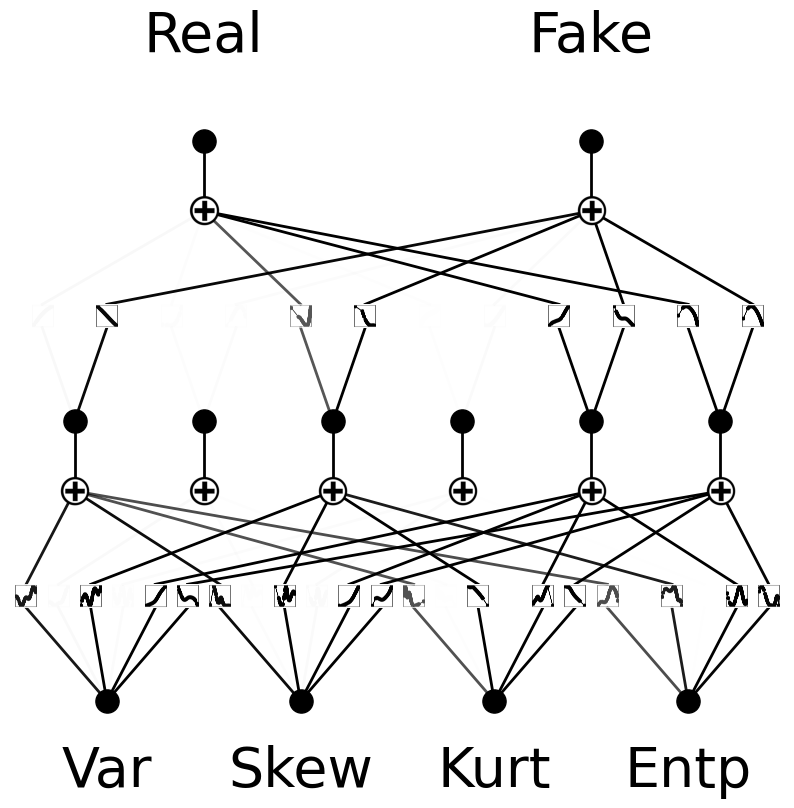

In [11]:
model.plot(beta=1000, scale=1,sample=True, in_vars=column_names, out_vars=target_names)

In [12]:
results['train_acc'][-1], results['test_acc'][-1]

(0.9948979616165161, 1.0)

In [13]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 636
Trainable parameters: 432


In [14]:
video_name='fin_video'
fps=2

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video fin_video.mp4.
Moviepy - Writing video fin_video.mp4



Moviepy - Done !
Moviepy - video ready fin_video.mp4


saving model version 0.2


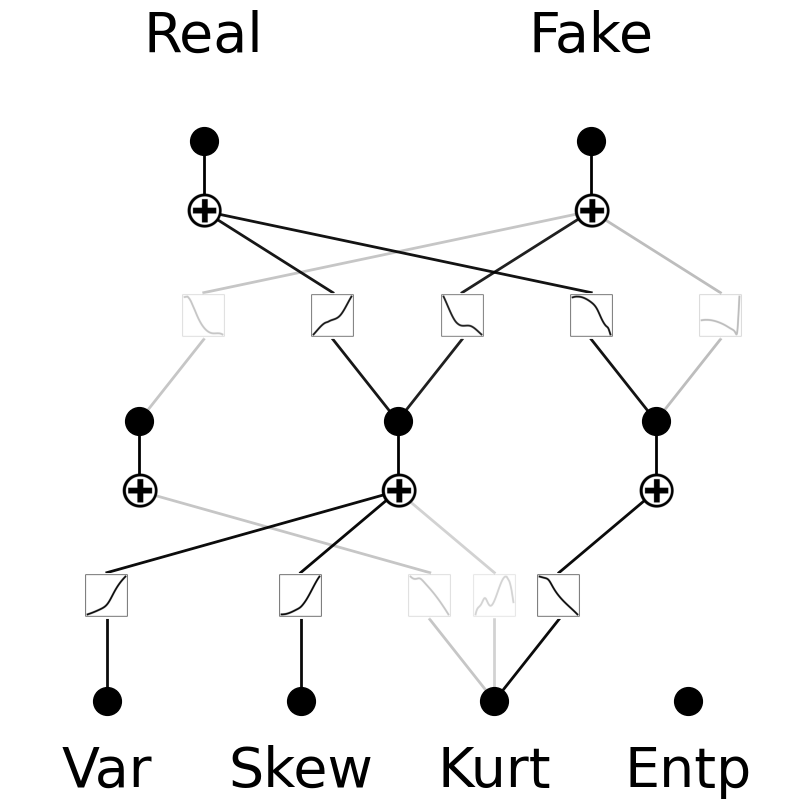

In [15]:
model = model.prune()
model(dataset['train_input'])
model.plot(beta=10,scale=1, in_vars=column_names, out_vars=target_names)

In [16]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 342
Trainable parameters: 216


| train_loss: 2.16e-01 | test_loss: 1.74e-01 | reg: 4.99e+01 | : 100%|█| 50/50 [04:41<00:00,  5.63s/


saving model version 0.4


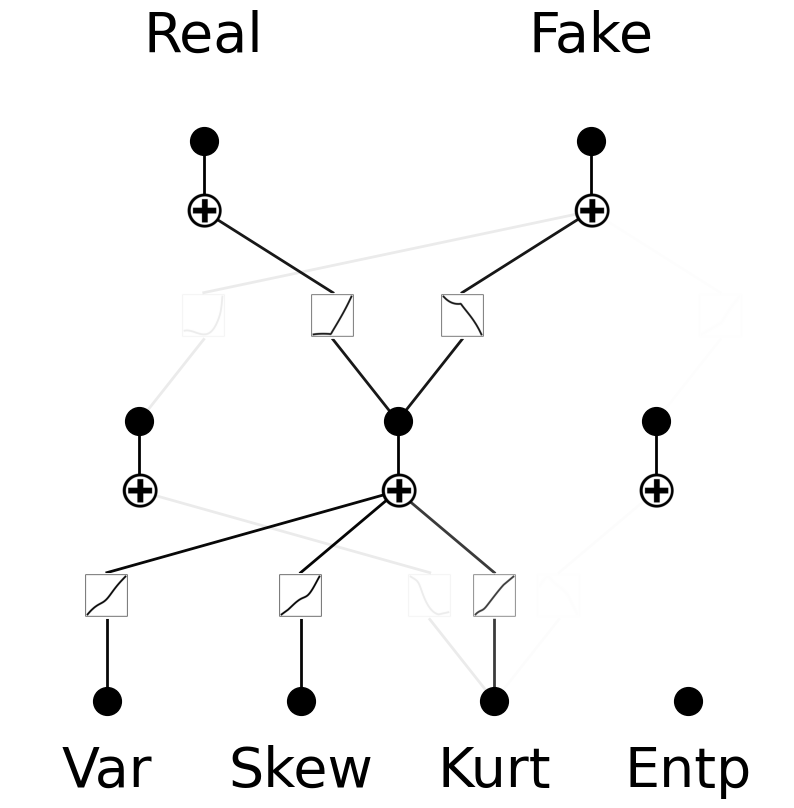

In [18]:
results =model.fit(dataset, opt="Adam", metrics=(train_acc, test_acc),
                    loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)
results['train_acc'][-1], results['test_acc'][-1]
model.plot(scale=1, in_vars=column_names, out_vars=target_names)

fixing (0,0,0) with 0
fixing (0,0,1) with x, r2=0.9767736196517944, c=1
fixing (0,0,2) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with x, r2=0.9491600394248962, c=1
fixing (0,1,2) with 0
fixing (0,2,0) with x, r2=0.9267177581787109, c=1
fixing (0,2,1) with x, r2=0.9769078493118286, c=1
fixing (0,2,2) with x, r2=0.4458305835723877, c=1
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (1,0,0) with 0
fixing (1,0,1) with exp, r2=0.9834622740745544, c=2
fixing (1,1,0) with x, r2=0.7048672437667847, c=1
fixing (1,1,1) with x, r2=0.8570248484611511, c=1
fixing (1,2,0) with x, r2=0.09058068692684174, c=1
fixing (1,2,1) with x, r2=0.9704704880714417, c=1
saving model version 0.5


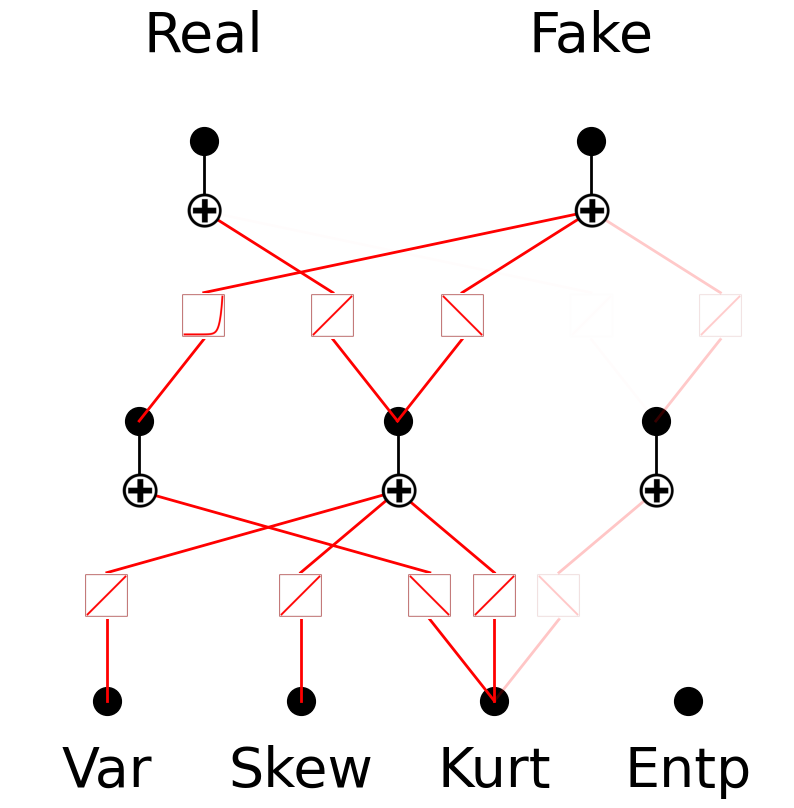

In [19]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
model(dataset['train_input'])
model.plot(beta=100,scale=1, in_vars=column_names, out_vars=target_names)

In [ ]:
results =model.fit(dataset, opt="Adam", metrics=(train_acc, test_acc),
                    loss_fn=torch.nn.CrossEntropyLoss(), steps=30, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)
results['train_acc'][-1], results['test_acc'][-1]

## sample comparision

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 6)  # 4 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(6, 2)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [29]:
def load_dataset(data_set,batch_size=512):
    dataset=data_set
    dataset = shuffle(dataset, random_state=42)
    data = dataset.drop('Label', axis=1).values
    target = dataset['Label'].values

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
    # scaler = StandardScaler()
    # train_data = scaler.fit_transform(train_data)
    # test_data = scaler.transform(test_data)

    # Convert to PyTorch tensors
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_target = torch.tensor(train_target, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_target = torch.tensor(test_target, dtype=torch.long)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=batch_size, shuffle=false)

    return train_loader, test_loader

train_loader, test_loader = load_dataset(data,batch_size=512)

In [30]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 0.8539565205574036
Epoch 2, Loss: 0.8027275204658508
Epoch 3, Loss: 0.7531962990760803
Epoch 4, Loss: 0.7054708003997803
Epoch 5, Loss: 0.6598780751228333
Epoch 6, Loss: 0.6166435480117798
Epoch 7, Loss: 0.5765080451965332
Epoch 8, Loss: 0.5396276116371155
Epoch 9, Loss: 0.5059813857078552
Epoch 10, Loss: 0.4755811393260956
Epoch 11, Loss: 0.4484301507472992
Epoch 12, Loss: 0.42395973205566406
Epoch 13, Loss: 0.4015459418296814
Epoch 14, Loss: 0.3806167244911194
Epoch 15, Loss: 0.3608306646347046
Epoch 16, Loss: 0.341937392950058
Epoch 17, Loss: 0.32384759187698364
Epoch 18, Loss: 0.30650192499160767
Epoch 19, Loss: 0.28983861207962036
Epoch 20, Loss: 0.2737198770046234
Epoch 21, Loss: 0.25844016671180725
Epoch 22, Loss: 0.24386022984981537
Epoch 23, Loss: 0.22997507452964783
Epoch 24, Loss: 0.21699023246765137
Epoch 25, Loss: 0.20493635535240173
Epoch 26, Loss: 0.19375266134738922
Epoch 27, Loss: 0.18319907784461975
Epoch 28, Loss: 0.17321033775806427
Epoch 29, Loss: 0.

In [31]:
test_model(model, test_loader)

Accuracy: 100.0%


In [32]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 44
Trainable parameters: 44


In [37]:
model.stats()

AttributeError: 'Net' object has no attribute 'stats'